# PCA + LDA Implementation for Image Classification

This notebook demonstrates:
1. **PCA (Principal Component Analysis)** - for dimensionality reduction
2. **LDA (Linear Discriminant Analysis)** - for classification
3. **Combined approach** - Using PCA first to reduce dimensions, then LDA for classification

We'll classify cat vs dog images from your dataset using manual implementations.

In [1]:
# --- Step 1: Import Libraries ---
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# --- Step 2: Data Loading Function ---
def load_data(dataset_path, img_size=64, test_size=0.2, random_state=42):
    """
    Load cat and dog images from the dataset folder
    
    Args:
        dataset_path: Path to the Dataset folder
        img_size: Size to resize images to (default 64x64)
        test_size: Fraction of data to use for testing
        random_state: Random seed for reproducibility
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    X = []
    y = []
    
    # Load cat images (label 0)
    cat_path = os.path.join(dataset_path, "Cat")
    if os.path.exists(cat_path):
        for img_file in os.listdir(cat_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(cat_path, img_file)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize((img_size, img_size))
                    arr = np.array(img).flatten() / 255.0
                    X.append(arr)
                    y.append(0)  # Cat = 0
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
    
    # Load dog images (label 1)
    dog_path = os.path.join(dataset_path, "Dog")
    if os.path.exists(dog_path):
        for img_file in os.listdir(dog_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(dog_path, img_file)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize((img_size, img_size))
                    arr = np.array(img).flatten() / 255.0
                    X.append(arr)
                    y.append(1)  # Dog = 1
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Loaded {len(X)} images total")
    print(f"Cats: {np.sum(y == 0)}, Dogs: {np.sum(y == 1)}")
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

print("Data loading function defined.")

Data loading function defined.


In [3]:
# --- Step 3: Manual PCA Implementation ---
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None

    def fit(self, X):
        """
        Fit PCA to the data using SVD approach (consistent with your SVD notebook)
        """
        print(f"Fitting PCA with {self.n_components} components...")
        
        # Center the data (subtract mean)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        print(f"Data centered by subtracting mean.")
        print(f"Centered data shape: {X_centered.shape}")
        
        # Apply SVD for efficiency (same approach as your SVD notebook)
        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
        
        print(f"SVD completed:")
        print(f"U shape: {U.shape}")
        print(f"s shape: {s.shape}")
        print(f"Vt shape: {Vt.shape}")
        
        # Take the top n_components
        self.components = Vt[:self.n_components]
        self.singular_values = s[:self.n_components]
        
        print(f"Selected top {self.n_components} components.")
        print(f"Components shape: {self.components.shape}")

    def transform(self, X):
        """
        Transform data to PCA space
        """
        X_centered = X - self.mean
        # Project onto principal components
        return X_centered @ self.components.T
    
    def fit_transform(self, X):
        """
        Fit PCA and transform data in one step
        """
        self.fit(X)
        return self.transform(X)

print("PCA class defined successfully!")

PCA class defined successfully!


In [4]:
# --- Step 4: Manual LDA Implementation ---
class LDA:
    def __init__(self):
        self.classes = None
        self.means = {}
        self.priors = {}
        self.cov_inv = None

    def fit(self, X, y):
        """
        Fit LDA to the training data
        """
        print("Fitting LDA classifier...")
        
        self.classes = np.unique(y)
        n_features = X.shape[1]
        
        print(f"Classes found: {self.classes}")
        print(f"Number of features: {n_features}")
        
        # Calculate class means and priors
        for c in self.classes:
            Xc = X[y == c]
            self.means[c] = np.mean(Xc, axis=0)
            self.priors[c] = Xc.shape[0] / X.shape[0]
            print(f"Class {c}: {Xc.shape[0]} samples, prior = {self.priors[c]:.3f}")

        # Calculate shared covariance matrix
        print("Computing shared covariance matrix...")
        cov = np.zeros((n_features, n_features))
        for c in self.classes:
            Xc = X[y == c]
            diff = Xc - self.means[c]
            cov += diff.T @ diff
        
        # Divide by (n - k) where k is number of classes
        cov /= X.shape[0] - len(self.classes)
        
        # Use pseudo-inverse for numerical stability
        self.cov_inv = np.linalg.pinv(cov)
        print(f"Covariance matrix computed and inverted.")

    def predict(self, X):
        """
        Predict class labels for new data
        """
        X = np.array(X)
        preds = []
        
        for x in X:
            scores = []
            for c in self.classes:
                mean = self.means[c]
                # LDA discriminant function
                score = (x @ self.cov_inv @ mean - 
                        0.5 * mean @ self.cov_inv @ mean + 
                        np.log(self.priors[c]))
                scores.append(score)
            
            # Predict class with highest score
            preds.append(self.classes[np.argmax(scores)])
        
        return np.array(preds)
    
    def predict_proba(self, X):
        """
        Predict class probabilities
        """
        X = np.array(X)
        probas = []
        
        for x in X:
            scores = []
            for c in self.classes:
                mean = self.means[c]
                score = (x @ self.cov_inv @ mean - 
                        0.5 * mean @ self.cov_inv @ mean + 
                        np.log(self.priors[c]))
                scores.append(score)
            
            # Convert to probabilities using softmax
            scores = np.array(scores)
            exp_scores = np.exp(scores - np.max(scores))  # Numerical stability
            probas.append(exp_scores / np.sum(exp_scores))
        
        return np.array(probas)

print("LDA class defined successfully!")

LDA class defined successfully!


In [5]:
# --- Step 5: Load Dataset ---
# Update the path to match your dataset location
dataset_path = "/Users/rishad/Downloads/Lab/Dataset"
img_size = 64  # Resize images to 64x64 pixels

print("Loading dataset...")
print(f"Dataset path: {dataset_path}")
print(f"Image size: {img_size}x{img_size}")

try:
    X_train, X_test, y_train, y_test = load_data(dataset_path, img_size=img_size)
    
    print(f"\n--- Dataset Summary ---")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Feature dimensions: {X_train.shape[1]} (flattened {img_size}x{img_size}x3 RGB)")
    print(f"Training labels distribution: Cats={np.sum(y_train == 0)}, Dogs={np.sum(y_train == 1)}")
    print(f"Test labels distribution: Cats={np.sum(y_test == 0)}, Dogs={np.sum(y_test == 1)}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check that the Dataset folder exists with Cat and Dog subfolders.")

Loading dataset...
Dataset path: /Users/rishad/Downloads/Lab/Dataset
Image size: 64x64
Loaded 100 images total
Cats: 50, Dogs: 50

--- Dataset Summary ---
Training samples: 80
Test samples: 20
Feature dimensions: 12288 (flattened 64x64x3 RGB)
Training labels distribution: Cats=40, Dogs=40
Test labels distribution: Cats=10, Dogs=10


In [6]:
# --- Step 6: Apply PCA for Dimensionality Reduction ---
n_components = 50  # Reduce to 50 dimensions

print(f"\n=== PCA DIMENSIONALITY REDUCTION ===")
print(f"Reducing from {X_train.shape[1]} to {n_components} dimensions...")

# Initialize and fit PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"\n--- PCA Results ---")
print(f"Original training data shape: {X_train.shape}")
print(f"PCA training data shape: {X_train_pca.shape}")
print(f"Original test data shape: {X_test.shape}")
print(f"PCA test data shape: {X_test_pca.shape}")

# Calculate compression ratio
original_size = X_train.shape[1]
compressed_size = n_components
compression_ratio = original_size / compressed_size

print(f"\n--- Compression Analysis ---")
print(f"Original dimensions: {original_size}")
print(f"Compressed dimensions: {compressed_size}")
print(f"Compression ratio: {compression_ratio:.2f} : 1")

# Show explained variance (approximate)
explained_variance_ratio = pca.singular_values**2 / np.sum(pca.singular_values**2)
cumulative_variance = np.cumsum(explained_variance_ratio)
print(f"Explained variance by top {n_components} components: {cumulative_variance[-1]:.3f} ({cumulative_variance[-1]*100:.1f}%)")


=== PCA DIMENSIONALITY REDUCTION ===
Reducing from 12288 to 50 dimensions...
Fitting PCA with 50 components...
Data centered by subtracting mean.
Centered data shape: (80, 12288)
SVD completed:
U shape: (80, 80)
s shape: (80,)
Vt shape: (80, 12288)
Selected top 50 components.
Components shape: (50, 12288)

--- PCA Results ---
Original training data shape: (80, 12288)
PCA training data shape: (80, 50)
Original test data shape: (20, 12288)
PCA test data shape: (20, 50)

--- Compression Analysis ---
Original dimensions: 12288
Compressed dimensions: 50
Compression ratio: 245.76 : 1
Explained variance by top 50 components: 1.000 (100.0%)


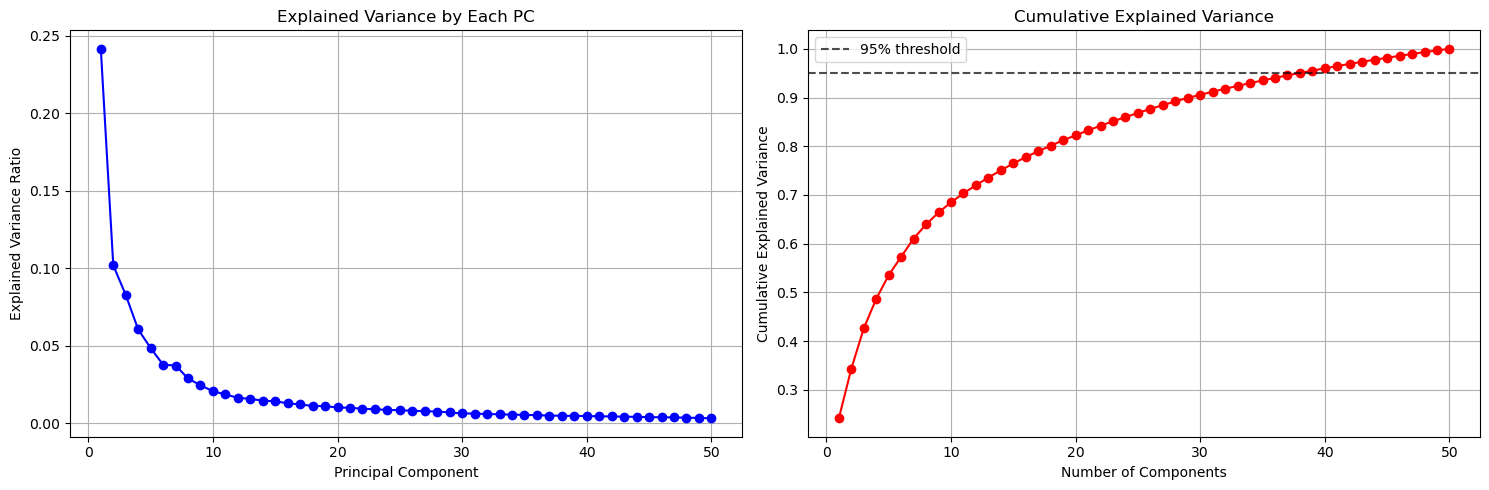

First 10 components explain 0.685 (68.5%) of variance
First 20 components explain 0.822 (82.2%) of variance


In [7]:
# --- Step 7: Visualize PCA Results ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance
axes[0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Each PC')
axes[0].grid(True)

# Plot cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].grid(True)
axes[1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"First 10 components explain {cumulative_variance[9]:.3f} ({cumulative_variance[9]*100:.1f}%) of variance")
print(f"First 20 components explain {cumulative_variance[19]:.3f} ({cumulative_variance[19]*100:.1f}%) of variance")

In [8]:
# --- Step 8: Train LDA on PCA Features ---
print(f"\n=== LDA CLASSIFICATION ===")
print("Training LDA on PCA-reduced features...")

# Initialize and train LDA
lda = LDA()
lda.fit(X_train_pca, y_train)

print("\nLDA training completed!")


=== LDA CLASSIFICATION ===
Training LDA on PCA-reduced features...
Fitting LDA classifier...
Classes found: [0 1]
Number of features: 50
Class 0: 40 samples, prior = 0.500
Class 1: 40 samples, prior = 0.500
Computing shared covariance matrix...
Covariance matrix computed and inverted.

LDA training completed!


In [9]:
# --- Step 9: Evaluate Model Performance ---
print(f"\n=== MODEL EVALUATION ===")

# Make predictions
print("Making predictions on test set...")
y_pred = lda.predict(X_test_pca)
y_pred_proba = lda.predict_proba(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Results ---")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed performance analysis
from sklearn.metrics import classification_report, confusion_matrix

print(f"\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

print(f"\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print("Predicted:   Cat  Dog")
print(f"Actual Cat:  {cm[0,0]:3d}  {cm[0,1]:3d}")
print(f"Actual Dog:  {cm[1,0]:3d}  {cm[1,1]:3d}")


=== MODEL EVALUATION ===
Making predictions on test set...

--- Results ---
Test Accuracy: 0.5000 (50.00%)

--- Classification Report ---
              precision    recall  f1-score   support

         Cat       0.50      0.60      0.55        10
         Dog       0.50      0.40      0.44        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.50      0.50      0.49        20


--- Confusion Matrix ---
Predicted:   Cat  Dog
Actual Cat:    6    4
Actual Dog:    6    4



=== PREDICTION VISUALIZATION ===


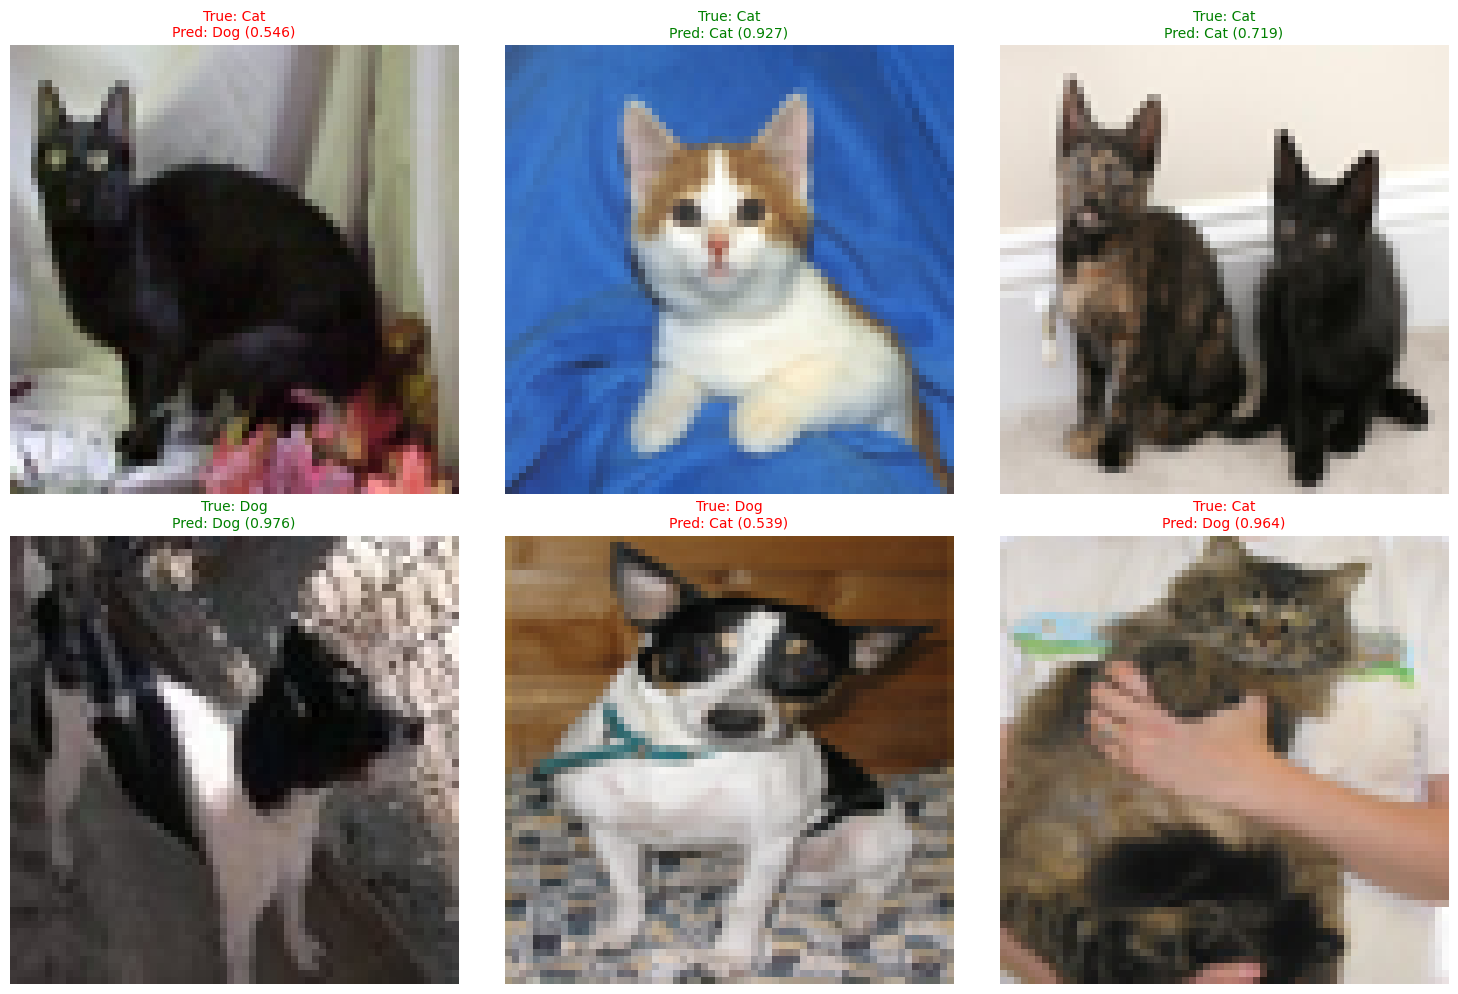

Green titles = Correct predictions
Red titles = Incorrect predictions


In [10]:
# --- Step 10: Visualize Some Predictions ---
print("\n=== PREDICTION VISUALIZATION ===")

# Select a few test samples to visualize
n_samples = 6
indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

class_names = ['Cat', 'Dog']

for i, idx in enumerate(indices):
    # Reshape flattened image back to original shape
    img = X_test[idx].reshape(img_size, img_size, 3)
    
    # Get prediction and probability
    pred_class = y_pred[idx]
    true_class = y_test[idx]
    pred_proba = y_pred_proba[idx]
    
    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Create title with prediction info
    title = f"True: {class_names[true_class]}\n"
    title += f"Pred: {class_names[pred_class]} ({pred_proba[pred_class]:.3f})"
    
    # Color code: green if correct, red if incorrect
    color = 'green' if pred_class == true_class else 'red'
    axes[i].set_title(title, color=color, fontsize=10)

plt.tight_layout()
plt.show()

print("Green titles = Correct predictions")
print("Red titles = Incorrect predictions")


=== TEST ON NEW IMAGE ===
Testing on: 974.jpg

--- Prediction Results ---
Predicted class: Cat
Confidence: 0.8815
Probabilities - Cat: 0.8815, Dog: 0.1185


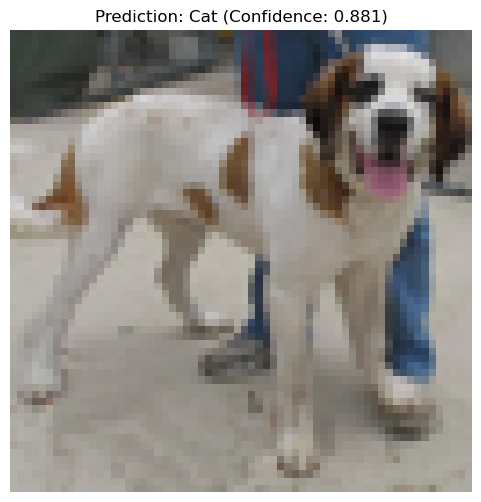

In [11]:
# --- Step 11: Test on New Image (Optional) ---
def load_single_image(img_path, img_size=64):
    """
    Load and preprocess a single image for prediction
    """
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((img_size, img_size))
        arr = np.array(img).flatten() / 255.0
        return arr
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

print("\n=== TEST ON NEW IMAGE ===")

# Test with your design image
test_img_path = "974.jpg"

if os.path.exists(test_img_path):
    print(f"Testing on: {test_img_path}")
    
    # Load and preprocess the image
    x_new = load_single_image(test_img_path, img_size=img_size)
    
    if x_new is not None:
        # Apply PCA transformation
        x_new_pca = pca.transform([x_new])
        
        # Make prediction
        pred = lda.predict(x_new_pca)
        pred_proba = lda.predict_proba(x_new_pca)
        
        print(f"\n--- Prediction Results ---")
        print(f"Predicted class: {class_names[pred[0]]}")
        print(f"Confidence: {pred_proba[0][pred[0]]:.4f}")
        print(f"Probabilities - Cat: {pred_proba[0][0]:.4f}, Dog: {pred_proba[0][1]:.4f}")
        
        # Display the image
        img_display = x_new.reshape(img_size, img_size, 3)
        plt.figure(figsize=(6, 6))
        plt.imshow(img_display)
        plt.title(f"Prediction: {class_names[pred[0]]} (Confidence: {pred_proba[0][pred[0]]:.3f})")
        plt.axis('off')
        plt.show()
    
else:
    print(f"Test image not found at: {test_img_path}")
    print("You can add any image to test the model!")

## Summary and Key Insights

### What We Accomplished:
1. **Manual PCA Implementation** - Reduced image dimensions from ~12,288 (64×64×3) to 50 features
2. **Manual LDA Implementation** - Used for binary classification (Cat vs Dog)
3. **Combined PCA + LDA Pipeline** - Efficient dimensionality reduction followed by classification

### Key Relationships to Previous Notebooks:
- **SVD Connection**: PCA uses SVD internally (same as your SVD notebook)
- **Eigen-decomposition**: PCA finds principal components (eigenvectors of covariance matrix)
- **Dimensionality Reduction**: Similar compression concepts as image compression

### Why This Approach Works:
- **PCA**: Captures most important variations in the data
- **LDA**: Finds optimal decision boundary between classes
- **Combined**: PCA handles curse of dimensionality, LDA focuses on discrimination

### Performance Factors:
- Number of PCA components affects both speed and accuracy
- More components = more information but slower computation
- Fewer components = faster but may lose important features